In [1]:
repo_directory = '/Users/iaincarmichael/Dropbox/Research/law/law-net/'
data_dir = '/Users/iaincarmichael/data/courtlistener/'

import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from scipy.stats import rankdata
import cPickle as pickle
from collections import Counter
import pandas as pd

# graph package
import igraph as ig

# our code
sys.path.append(repo_directory + 'code/')
from setup_data_dir import setup_data_dir, make_subnetwork_directory
from pipeline.download_data import download_bulk_resource, download_master_edgelist, download_scdb
from helpful_functions import case_info
from viz import print_describe
from stats.linear_model import *

sys.path.append(repo_directory + 'vertex_metrics_experiment/code/')

from custom_vertex_metrics import *


# which network to download data for
network_name = 'scotus' # 'federal', 'ca1', etc


# some sub directories that get used
raw_dir = data_dir + 'raw/'
subnet_dir = data_dir + network_name + '/'
text_dir = subnet_dir + 'textfiles/'


# jupyter notebook settings
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
G = ig.Graph.Read_GraphML(subnet_dir + network_name +'_network.graphml')

# text length vs outdegree

In [3]:
num_words = np.array(G.vs['num_words'])

outdegrees = np.array(G.outdegree())

indegrees = G.indegree()

years = G.vs['year']

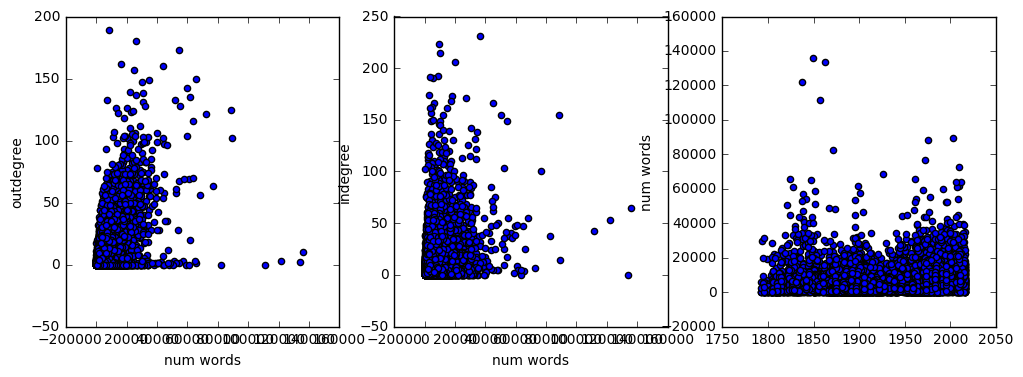

In [4]:
plt.figure(figsize=[12, 4])

plt.subplot(1,3,1)
plt.scatter(num_words, outdegrees)
plt.xlabel('num words')
plt.ylabel('outdegree')

plt.subplot(1,3,2)
plt.scatter(num_words, indegrees)
plt.xlabel('num words')
plt.ylabel('indegree')

plt.subplot(1,3,3)
plt.scatter(years, num_words)
plt.ylabel('year')
plt.ylabel('num words')


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                 1.591e+04
Date:                Sat, 14 Jan 2017   Prob (F-statistic):               0.00
Time:                        18:58:30   Log-Likelihood:            -1.0368e+05
No. Observations:               27885   AIC:                         2.074e+05
Df Residuals:                   27883   BIC:                         2.074e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.9941      0.078     25.439      0.0

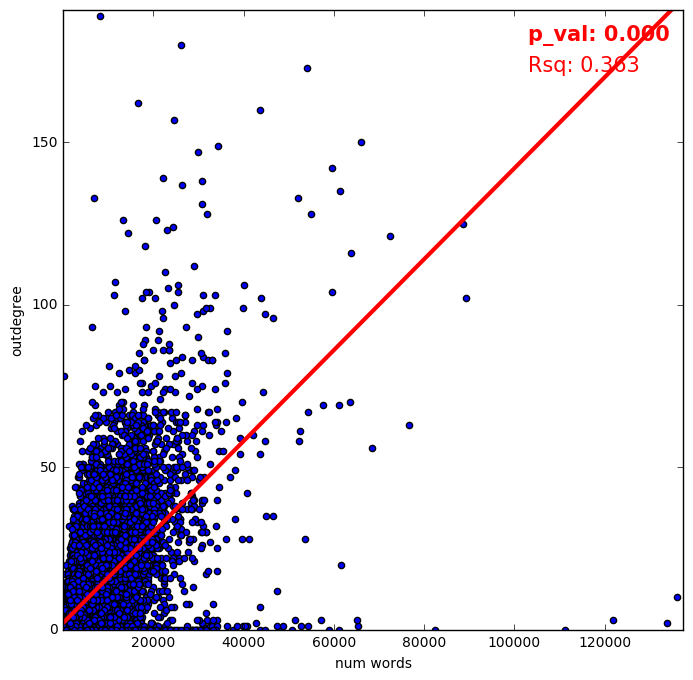

In [58]:
get_SLR(num_words, outdegrees, xlabel='num words', ylabel='outdegree')

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                 1.595e+04
Date:                Sat, 14 Jan 2017   Prob (F-statistic):               0.00
Time:                        19:05:17   Log-Likelihood:                -95606.
No. Observations:               27435   AIC:                         1.912e+05
Df Residuals:                   27433   BIC:                         1.912e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.2585      0.069     18.171      0.0

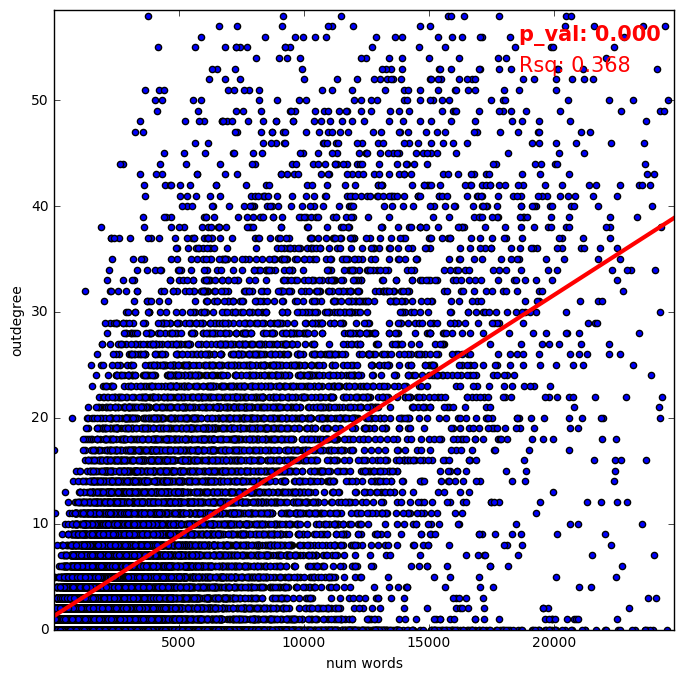

In [62]:
# remove cases with extremes
out_deg_upper = np.percentile(outdegrees, 99)
out_deg_lower = np.percentile(outdegrees, 0)

num_words_upper = np.percentile(num_words, 99)
num_words_lower = np.percentile(num_words, 0)

od_to_keep = (out_deg_lower <= outdegrees) & (outdegrees <= out_deg_upper)
nw_to_keep = (num_words_lower <= num_words) & (num_words <= num_words_upper)
to_keep =  od_to_keep & nw_to_keep

# remove cases that have zero out-degree
get_SLR(num_words[to_keep], outdegrees[to_keep], xlabel='num words', ylabel='outdegree')

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     3944.
Date:                Mon, 09 Jan 2017   Prob (F-statistic):               0.00
Time:                        21:10:14   Log-Likelihood:            -1.1029e+05
No. Observations:               27885   AIC:                         2.206e+05
Df Residuals:                   27883   BIC:                         2.206e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          4.3593      0.099     43.888      0.0

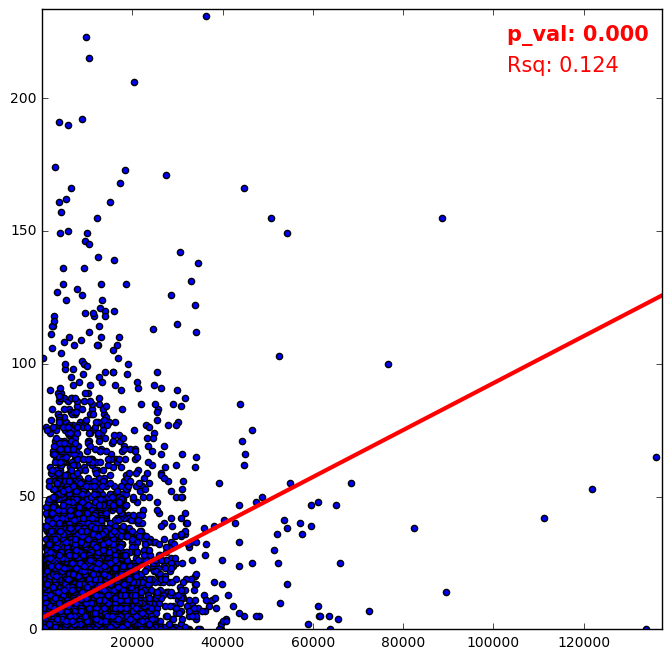

In [60]:
get_SLR(num_words, indegrees)

# text length over time

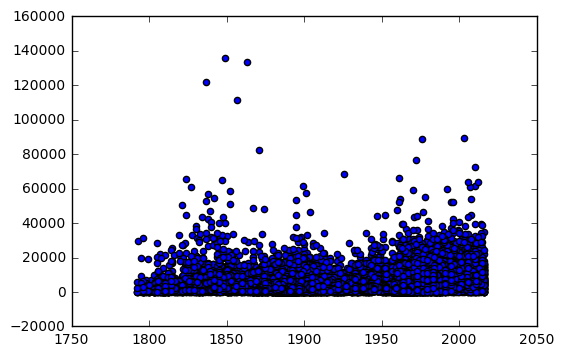

In [40]:
plt.scatter(years, num_words)

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     1828.
Date:                Mon, 09 Jan 2017   Prob (F-statistic):               0.00
Time:                        20:54:52   Log-Likelihood:            -2.7821e+05
No. Observations:               27885   AIC:                         5.564e+05
Df Residuals:                   27883   BIC:                         5.564e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       -4.86e+04   1244.086    -39.067      0.0

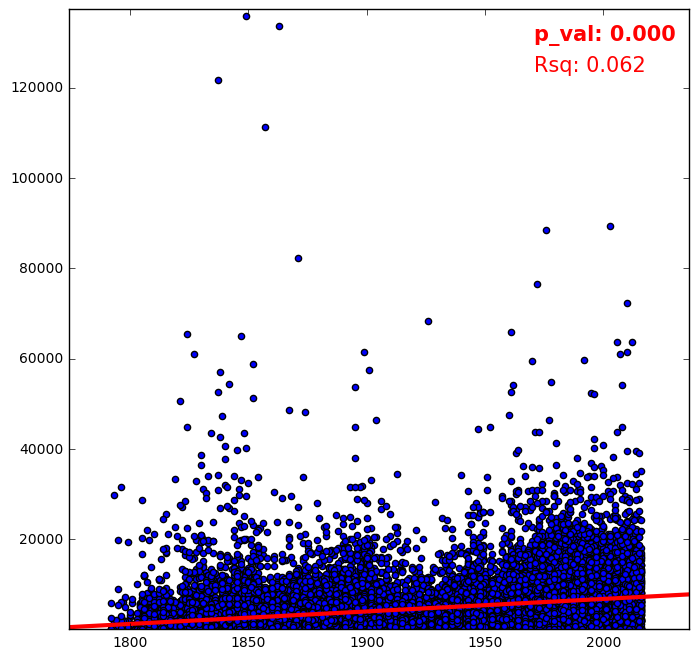

In [41]:
get_SLR(years, num_words)

In [66]:
def get_year_aggregate(years, x, fcn):
    by_year = {y: [] for y in set(years)}
    for i in range(len(years)):
        by_year[years[i]].append(x[i])
    
    year_agg_dict = {y: fcn(by_year[y]) for y in by_year.keys()}
    return pd.Series(year_agg_dict)

in_year_median = get_year_aggregate(years, indegrees, np.median)

nw_year_median = get_year_aggregate(years, num_words, np.median)

od_year_median = get_year_aggregate(years, outdegrees, np.median)

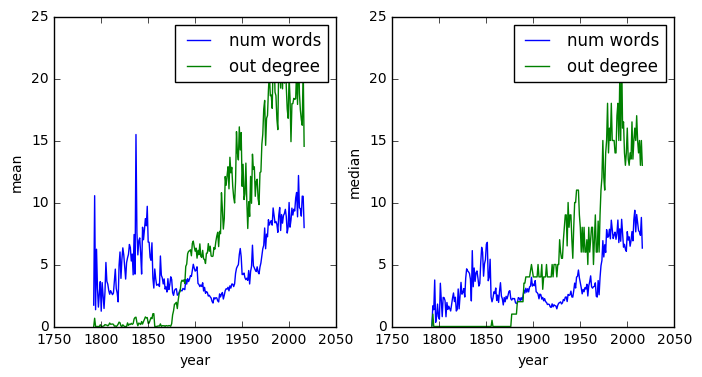

In [49]:
plt.figure(figsize=[8, 4])
plt.subplot(1,2,1)
plt.plot(nw_year_mean.index, nw_year_mean/1000, label='num words')
plt.plot(od_year_mean.index, od_year_mean, label='out degree')
plt.ylabel('mean')
plt.xlabel('year')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.plot(nw_year_median.index, wl_year_median/1000, label='num words')
plt.plot(od_year_median.index, od_year_median, label='out degree')

plt.ylabel('median')
plt.xlabel('year')
plt.legend(loc='upper right')

(0, 30)

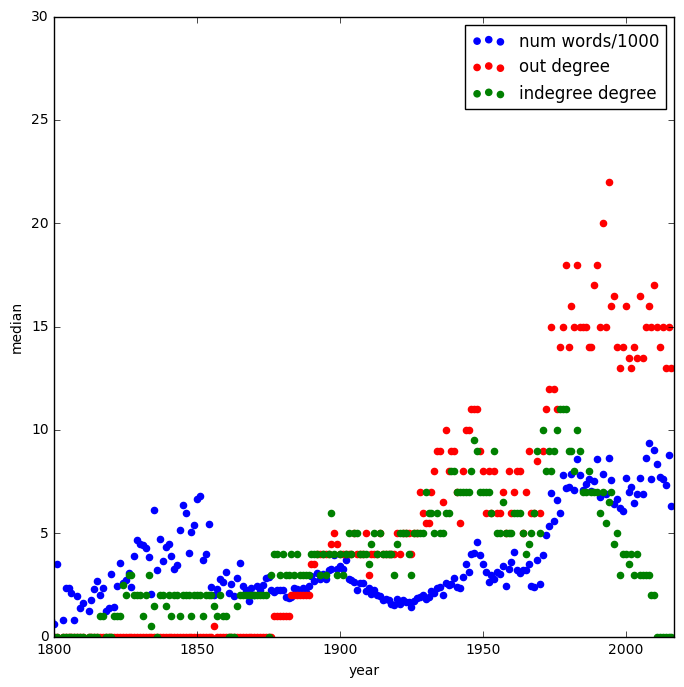

In [71]:
plt.figure(figsize=[8, 8])
plt.scatter(nw_year_median.index, wl_year_median/1000,
            label='num words/1000', color='blue')
plt.scatter(od_year_median.index, od_year_median,
            label='out degree',  color='red')
plt.scatter(in_year_median.index, in_year_median,
            label='indegree degree',  color='green')
plt.ylabel('median')
plt.xlabel('year')
plt.legend(loc='upper right')
plt.xlim([1800, 2017])
plt.ylim([0, 30])


In [99]:
import networkx as nx

In [96]:
Gnx = nx.read_graphml(subnet_dir + network_name +'_network.graphml')

In [103]:
%%time
katz = nx.katz_centrality(Gnx)

CPU times: user 18.3 s, sys: 208 ms, total: 18.5 s
Wall time: 18.5 s
